Import necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

Define a class for training Hopfield Network.

In [2]:
class HopfieldNetwork:
    
    def __init__(self, bias=None):
        self.weights = None
        self.bias = bias
        self.positions_to_update = []

    # Define a function for computing the weights matrix
    def train(self, patterns, synchronous=False, average_activity=None, check=True,warn=True):
        if average_activity is not None:
            mu = average_activity
            self.weights = np.sum([(p.reshape((-1,1))-mu)@(p.reshape((1,-1))-mu) for p in patterns], 
                                  axis=0)
        else:
            self.weights = np.sum([p.reshape((-1,1))@p.reshape((1,-1)) for p in patterns], axis=0)
        self.weights = self.weights.astype(np.float64).copy()
        self.weights /= self.weights.shape[0]
        
        # Check if all patterns are well stored by recalling (if required)
        if check:
            successes = 0
            for pattern in patterns:
                recalled = self.recall(pattern, synchronous=synchronous)
                if np.array_equal(recalled, pattern):
                    successes += 1
                elif warn:
                    print("Warning: input pattern is not a fixed point ", pattern, recalled)
            if warn:
                print(successes, " patterns memorized successfully")
            
            return successes
    
    # Define a function for doing 1 recall (updating once all pattern dimensions)
    def update(self, pattern, synchronous=False, seed=0):
        if synchronous:
            if self.bias is not None:
                pattern_update = np.sign(self.weights@pattern-self.bias)
                pattern_update[pattern_update==0] = 1
                pattern_update = 0.5+0.5*pattern_update
            else:
                pattern_update = np.sign(self.weights@pattern)
                pattern_update[pattern_update==0] = 1
        else:
            # List all patterns dimensions not updated yet (in this complete recall)
            if not self.positions_to_update:
                self.positions_to_update = [i for i in range(pattern.shape[0])]
            
            # Select randomly one position to update
            np.random.seed(seed)
            j = np.random.choice(self.positions_to_update)
            
            # Update the chosen position
            pattern_update = pattern.copy()
            if self.bias is not None:
                value = np.sign(np.sum(self.weights[j,:]*pattern)-self.bias)
                pattern_update[j] = 0.5+0.5*(1 if value>=0 else -1)
            else:
                value = np.sign(np.sum(self.weights[j,:]*pattern))
                pattern_update[j] = 1 if value>=0 else -1
            self.positions_to_update.remove(j)
        
        return pattern_update
    
    # Define a function for doing a complete recall (all pattern dimensions)
    def recall(self, pattern, synchronous=False, max_iterations=None, return_iterations=False):
        iteration = 0
        while not(max_iterations is not None and iteration<max_iterations):
            if synchronous:
                pattern_update = self.update(pattern, synchronous=True)
            else:
                pattern_update = pattern
                for _ in range(pattern.shape[0]):
                    pattern_update = self.update(pattern_update, synchronous=False)
            if np.array_equal(pattern_update, pattern):
                break
            else:
                iteration += 1
                pattern = pattern_update
        
        if return_iterations:
            return pattern, iteration
        else:
            return pattern
    
    # Define a function to find all possible attractors
    def attractors(self, synchronous=False):
        attractors = set()
        all_possible_patterns = binary_patterns(self.weights.shape[1])
        for pattern in all_possible_patterns:
            attractors.add(tuple(self.recall(pattern, synchronous=synchronous)))
        
        return np.array([np.array(attractor) for attractor in attractors])
    
    # Define a function to compute the energy of a state or pattern
    def energy(self, state):
        alpha = state.reshape((-1,1))@state.reshape((1,-1))
        return -np.sum(alpha*self.weights)

def binary_patterns(length):
    for combination in range(2**length):
        combination_string = bin(combination)[2:].zfill(length)
        yield np.array([1 if x=='1' else -1 for x in combination_string], dtype=np.int8)

### 3.1 Convergence and attractors

Train Hopfield Network with the example data.

In [3]:
TRAINING_PATTERNS = np.array([[-1,-1,1,-1,1,-1,-1,1],
                              [-1,-1,-1,-1,-1,1,-1,-1],
                              [-1,1,1,-1,-1,1,-1,1]], dtype=np.int8)
model = HopfieldNetwork()
model.train(TRAINING_PATTERNS)

3  patterns memorized successfully


Can the memory recall the stored patterns from distorted inputs patterns? Apply the update rule repeatedly until you reach a stable fixed point. Did all the patterns converge towards stored patterns?

In [4]:
def test_recall(model, pattern_distorted, pattern_expected, synchronous=False, silent=False):
    pattern_recalled = model.recall(pattern_distorted, synchronous=synchronous)
    good_recall_or_not = np.array_equal(pattern_recalled, pattern_expected)
    if not silent:
        message = 'Success' if good_recall_or_not else 'Failure'
        print(pattern_distorted," => ", pattern_recalled, " ", message)
    
    return good_recall_or_not

In [5]:
DISTORTED_PATTERNS = np.array([[1, -1, 1, -1, 1, -1, -1, 1],
                               [1, 1, -1, -1, -1, 1, -1, -1],
                               [1, 1, 1, -1, -1, 1, -1, 1]], dtype=np.int8)

print("Synchronous")
for expected, distorted in zip(TRAINING_PATTERNS, DISTORTED_PATTERNS):
    test_recall(model, distorted, expected, synchronous=False)

print("\nAsynchronous")
for expected, distorted in zip(TRAINING_PATTERNS, DISTORTED_PATTERNS):
    test_recall(model, distorted, expected, synchronous=True)

Synchronous
[ 1 -1  1 -1  1 -1 -1  1]  =>  [-1 -1  1 -1  1 -1 -1  1]   Success
[ 1  1 -1 -1 -1  1 -1 -1]  =>  [-1  1 -1 -1 -1  1 -1 -1]   Failure
[ 1  1  1 -1 -1  1 -1  1]  =>  [-1  1  1 -1 -1  1 -1  1]   Success

Asynchronous
[ 1 -1  1 -1  1 -1 -1  1]  =>  [-1. -1.  1. -1.  1. -1. -1.  1.]   Success
[ 1  1 -1 -1 -1  1 -1 -1]  =>  [-1.  1. -1. -1. -1.  1. -1. -1.]   Failure
[ 1  1  1 -1 -1  1 -1  1]  =>  [-1.  1.  1. -1. -1.  1. -1.  1.]   Success


How many attractors are there in this network?

In [6]:
attractors = model.attractors()
print("Found {} attractors:".format(len(attractors)))
for attractor in attractors:
      print(np.array(attractor))

Found 14 attractors:
[-1 -1  1 -1  1  1 -1  1]
[ 1  1  1  1 -1  1  1  1]
[ 1  1 -1  1 -1  1  1 -1]
[-1  1 -1 -1 -1  1 -1 -1]
[-1 -1 -1 -1 -1  1 -1 -1]
[-1  1  1 -1  1 -1 -1  1]
[ 1  1 -1  1  1  1  1 -1]
[-1 -1  1 -1 -1  1 -1  1]
[ 1  1  1  1  1 -1  1  1]
[-1 -1  1 -1  1 -1 -1  1]
[ 1  1 -1  1  1 -1  1 -1]
[ 1 -1 -1  1  1 -1  1 -1]
[-1 -1 -1 -1  1 -1 -1 -1]
[-1  1  1 -1 -1  1 -1  1]


What happens when you make the starting pattern even more dissimilar to the stored ones (e.g. more than half is wrong)?

In [7]:
def test_noisy_recall(model, patterns, synchronous=False):
    pattern_size = patterns.shape[1]
    indexes = np.arange(pattern_size)
    good_recalls_by_pattern_distortion = [[] for _ in patterns]
    
    # Iterate percentages of distortion
    for percentage_distortion in range(101):
        sys.stdout.write(str(percentage_distortion)+"% Distortion\r")
        
        # Iterate patterns
        for i, pattern in enumerate(patterns):
            good_recalls = 0
            
            # Iterate 100 random times to distort differently the pattern
            for seed in range(100):
                n_distortion = int(percentage_distortion/100*pattern_size)
                indexes_distorsion = np.random.choice(indexes, n_distortion, replace=False) 
                distorted = pattern.copy()
                distorted[indexes_distorsion] *= -1
                good_recalls += test_recall(model, distorted, pattern, synchronous=synchronous, 
                                            silent=True)
            good_recalls_by_pattern_distortion[i].append(good_recalls)
    
    # Plot the percentage of correct recalls by distortion levels
    plt.figure(figsize=(7.5,5))
    for i, good_recalls_by_distortion in enumerate(good_recalls_by_pattern_distortion):
        plt.plot(range(101), good_recalls_by_distortion, label=patterns[i])
    if synchronous:
        plt.title("Synchronous Updates")
    else:
        plt.title("Asynchronous Updates")
    plt.xlabel("Distortion Bitflips (Percent)")
    plt.ylabel("Correctly Recalled Patterns (Percent)")
    plt.legend()
    plt.grid()

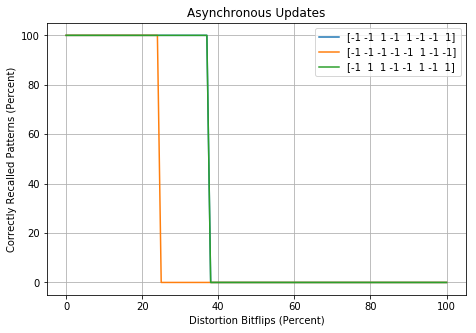

In [8]:
test_noisy_recall(model, TRAINING_PATTERNS, synchronous=False)

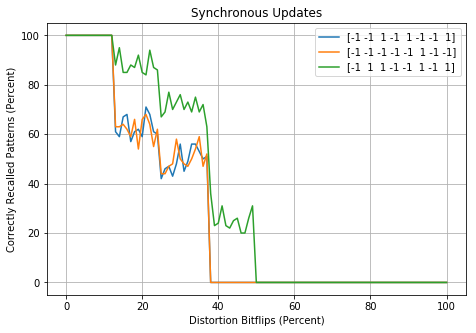

In [9]:
test_noisy_recall(model, TRAINING_PATTERNS, synchronous=True)

### 3.2 Sequential Update

Load images.

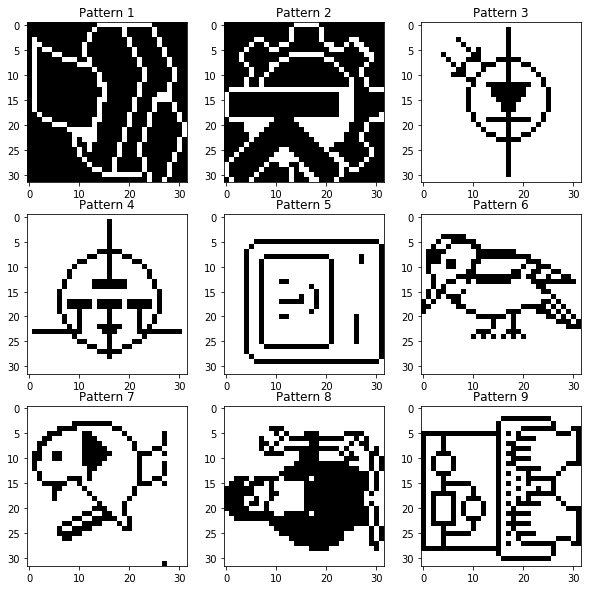

In [10]:
pict = np.genfromtxt('pict.dat', delimiter=',', dtype=np.int8).reshape(-1,1024)
fig = plt.figure(figsize=(10,10))
for i, pattern in enumerate(pict[:9,:]):
    fig.add_subplot(330+i+1)
    plt.imshow(pattern.reshape(32, 32), cmap='gray')
    plt.title("Pattern "+str(i+1))

Check that the three first patterns or images are stable.

In [11]:
model_pict = HopfieldNetwork()
model_pict.train(pict[:3,:], synchronous=False, average_activity=None, check=True, warn=True)

3  patterns memorized successfully


Can the network complete a degraded pattern? Try the pattern p10, which is a degraded version of p1, or p11 which is a mixture of p2 and p3.

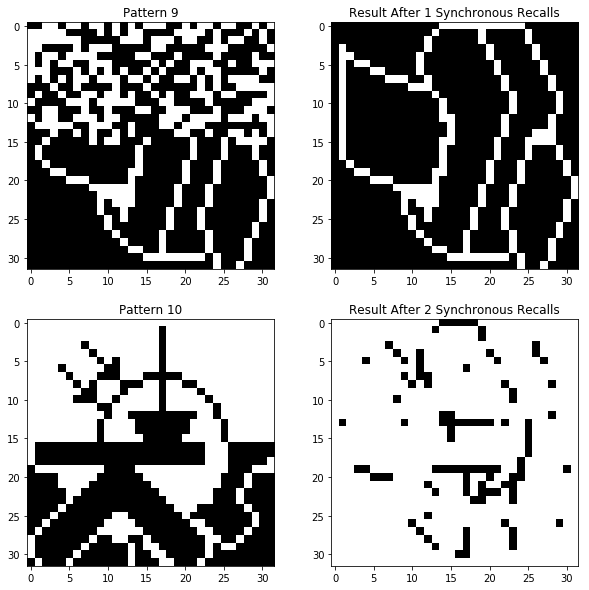

In [12]:
fig = plt.figure(figsize=(10,10))

fig.add_subplot(221)
plt.imshow(pict[10-1,:].reshape(32, 32), cmap='gray')
plt.title("Pattern 9")

fig.add_subplot(222)
patterns_recalled, iterations = model_pict.recall(pict[10-1,:], synchronous=True, return_iterations=True)
plt.imshow(patterns_recalled.reshape(32, 32), cmap='gray')
plt.title("Result After {} Synchronous Recalls".format(iterations))

fig.add_subplot(223)
plt.imshow(pict[11-1,:].reshape(32, 32), cmap='gray')
plt.title("Pattern 10")

fig.add_subplot(224)
patterns_recalled, iterations = model_pict.recall(pict[11-1,:], synchronous=True, return_iterations=True)
plt.imshow(patterns_recalled.reshape(32, 32), cmap='gray')
plt.title("Result After {} Synchronous Recalls".format(iterations))

What happens if we select units randomly? Please calculate their new state and then repeat the process in the spirit of the original sequential Hopfield dynamics. Please demonstrate the image every hundredth iteration or so.

In [13]:
def sequential_series(pattern, iterations):
    fig = plt.figure(figsize=(15,10))
    current_iteration = 0
    for i, iteration in enumerate(iterations):
        fig.add_subplot(1, len(iterations), i+1)
        pattern_update = pattern
        for _ in range(current_iteration, iteration):
            pattern_update = model_pict.update(pattern_update, synchronous=False)
        pattern = pattern_update
        plt.imshow(pattern.reshape(32, 32), cmap='gray')
        plt.title("{} Iterations".format(iteration))
        current_iteration = iteration

Let's plot one complete recall asynchronous, showing the recall process after each 256 randomly selected pattern dimensions.

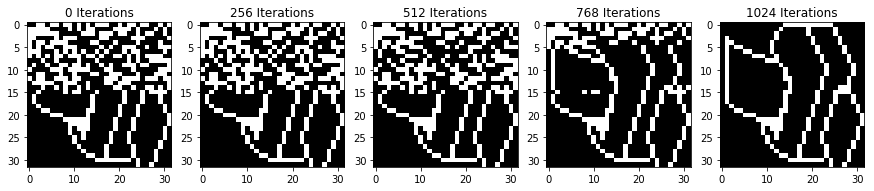

In [14]:
sequential_series(pict[9,:], iterations=range(0, 1025, 256))

### 3.3. Energy

What is the energy at the different attractors?

In [15]:
for attractor in model.attractors():
    print("{} => {}".format(attractor, model.energy(attractor)))

[-1 -1  1 -1  1  1 -1  1] => -7.0
[ 1  1  1  1 -1  1  1  1] => -4.5
[ 1  1 -1  1 -1  1  1 -1] => -8.5
[-1  1 -1 -1 -1  1 -1 -1] => -7.0
[-1 -1 -1 -1 -1  1 -1 -1] => -8.5
[-1  1  1 -1  1 -1 -1  1] => -7.0
[ 1  1 -1  1  1  1  1 -1] => -7.0
[-1 -1  1 -1 -1  1 -1  1] => -8.5
[ 1  1  1  1  1 -1  1  1] => -8.5
[-1 -1  1 -1  1 -1 -1  1] => -8.5
[ 1  1 -1  1  1 -1  1 -1] => -8.5
[ 1 -1 -1  1  1 -1  1 -1] => -9.0
[-1 -1 -1 -1  1 -1 -1 -1] => -4.5
[-1  1  1 -1 -1  1 -1  1] => -9.0


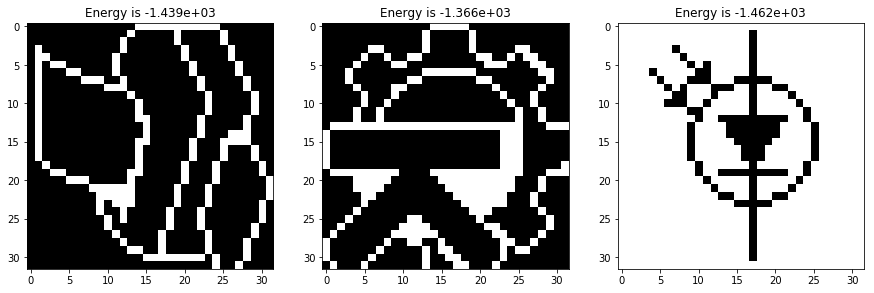

In [16]:
fig = plt.figure(figsize=(15,5))
for i, attractor in enumerate(pict[:3,:]):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(attractor.reshape(32, 32), cmap='gray')
    plt.title("Energy is {:1.3e}".format(model_pict.energy(attractor)))

What is the energy at the points of the distorted patterns?

In [17]:
for pattern in DISTORTED_PATTERNS:
    print("{} => {}".format(pattern, model.energy(pattern)))

[ 1 -1  1 -1  1 -1 -1  1] => -5.0
[ 1  1 -1 -1 -1  1 -1 -1] => -4.5
[ 1  1  1 -1 -1  1 -1  1] => -4.5


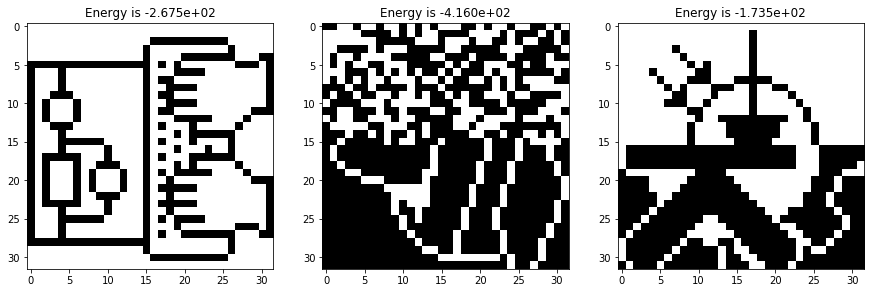

In [18]:
fig = plt.figure(figsize=(15,5))
for i, attractor in enumerate(pict[8:11,:]):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(attractor.reshape(32, 32), cmap='gray')
    plt.title("Energy is {:1.3e}".format(model_pict.energy(attractor)))

Follow how the energy changes from iteration to iteration when you use the sequential update rule to approach an attractor.

In [19]:
def plot_recall_energy_curve(model, pattern, max_iterations=None):
    pattern_init = pattern
    fig = plt.figure(figsize=(5,5))
    energies = [model.energy(pattern)]
    iteration = 0
    while True if max_iterations is None else iteration<max_iterations:
        iteration += 1
        pattern_update = pattern
        for _ in range(pattern.shape[0]):
            pattern_update = model.update(pattern_update, synchronous=False)
            energies.append(model.energy(pattern_update))
        if np.array_equal(pattern_update, pattern):
            break
        else:
            pattern = pattern_update
            
    plt.plot(energies, alpha=0.7, linewidth=2)
    for i in range(0, iteration*pattern.shape[0]+1, pattern.shape[0]):
        plt.axvline(i, color='r', linestyle='--')
    plt.title("{} => {}".format(pattern_init, pattern))
    plt.xlabel("Asynchronous updates")
    plt.ylabel("Energy")
    plt.grid()

- For the binary pattern of 8 dimensions that require more updates.

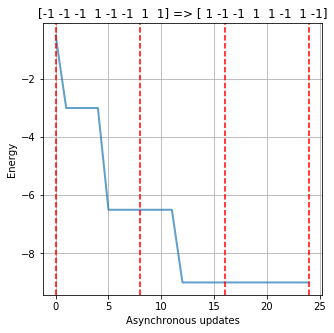

In [20]:
pattern_max_iterations = None
max_iterations = 0
for pattern in binary_patterns(8):
    _, iterations = model.recall(pattern, return_iterations=True)
    if iterations>max_iterations:
        max_iterations = iterations
        pattern_max_iterations = pattern

plot_recall_energy_curve(model, pattern_max_iterations)

- For the image 9.

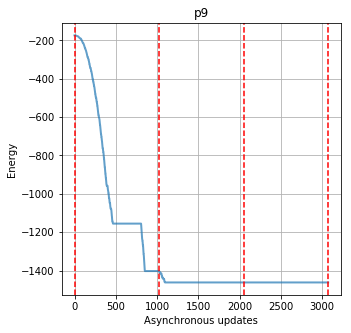

In [21]:
plot_recall_energy_curve(model_pict, pict[10,:])
plt.title("p9")

Generate a weight matrix by setting the weights to normally distributed random numbers, and try iterating an arbitrary starting state. What happens?

- For the binary pattern of 8 dimensions that require more updates.

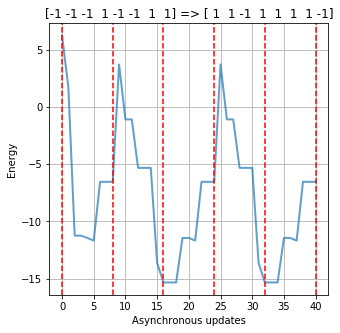

In [22]:
np.random.seed(0)
model_random = HopfieldNetwork()
model_random.weights = np.random.randn(8, 8)
plot_recall_energy_curve(model_random, pattern_max_iterations, max_iterations=5)

- For the image 9.

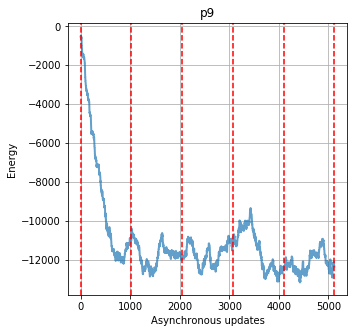

In [23]:
np.random.seed(0)
model_pict_random = HopfieldNetwork()
model_pict_random.weights = np.random.randn(1024, 1024)
plot_recall_energy_curve(model_pict_random, pict[10,:], max_iterations=5)
plt.title("p9")

Make the weight matrix symmetric (e.g. by setting w=0.5*(w+w')). What happens now? Why?

- For the binary pattern of 8 dimensions that require more updates.

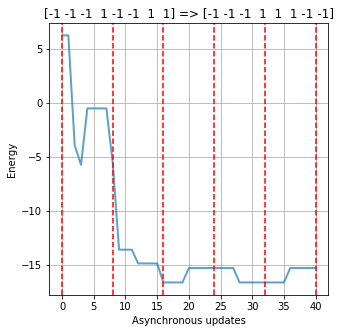

In [24]:
model_symmetric = model_random
model_symmetric.weights = 0.5*(model_symmetric.weights+model_symmetric.weights.T)
plot_recall_energy_curve(model_symmetric, pattern_max_iterations, max_iterations=5)

- For the image 9.

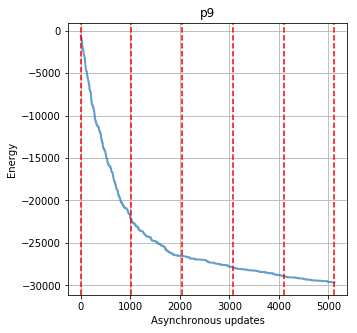

In [25]:
model_pict_symmetric = model_pict_random
model_pict_symmetric.weights = 0.5*(model_pict_symmetric.weights+model_pict_symmetric.weights.T)
plot_recall_energy_curve(model_pict_symmetric, pict[10,:], max_iterations=5)
plt.title("p9")

### 3.4. Distortion Resistance

In particular, train a network with p1, p2, p3, add noise to a pattern, iterate it a number of times and check whether it has been successfully restored. Let the script run across 0 to 100% noise and plot the result. For speed, use the Little model rather than asynchronous updates.

- How much noise can be removed?

- Is there any difference between the three attractors with regard to noise tolerance?

- Does the network always converge to the right attractor? Do the extra iterations (beyond a single-step recall) help? Do you notice any other attractors?

In [26]:
def profile_noise_resistance(model, patterns_list, synchronous=True): 
    
    # Define plots axes
    _,axes = plt.subplots(2+len(patterns_list), 1, figsize=(10,5*(2+len(patterns_list))))
    axes_recalls = axes[0]
    axes_iterations = axes[1]
    axes_attractors = axes[2:]
    
    # Iterate patterns
    pattern_size = patterns_list[0].shape[0]
    indexes = np.arange(pattern_size)
    attractors = patterns_list.copy()
    for i, pattern in enumerate(patterns_list):
        good_recalls_by_distortion = []
        iterations_by_distortion = []
        attractors_by_distortion = []
        
        # Iterate noise levels
        for percentage_distortion in range(101):
            sys.stdout.write("Pattern "+str(i+1)+" "+str(percentage_distortion)+"% Distortion\r")
            good_recalls_in_this_distortion = 0
            iterations_in_this_distortion = []
            attractors_in_this_distortion = []
            
            # Iterate andom iteration for randomly distorting the pattern
            for _ in range(100):
                
                # Create noisy version of pattern
                distorted = pattern.copy()
                amount = int(percentage_distortion/100*pattern_size)
                indexes_distorsion = np.random.choice(indexes, amount, replace=False)
                distorted[indexes_distorsion] *= -1
               
                # Try to recall the noisy pattern
                pattern_recalled, iterations = model.recall(distorted, synchronous=synchronous, 
                                                            return_iterations=True)
                
                # Record if it is a good recall
                if np.array_equal(pattern_recalled, pattern):
                    good_recalls_in_this_distortion += 1
                    iterations_in_this_distortion.append(iterations)
                
                # Record which attractor the algorithm has converged to
                is_it_new_fixedpoint = True
                for attractor_id, attractor in enumerate(attractors):
                    if np.array_equal(pattern_recalled, attractor):
                        attractors_in_this_distortion.append(attractor_id)
                        is_it_new_fixedpoint = False
                        break
                if is_it_new_fixedpoint:
                    attractors.append(pattern_recalled)
                    attractors_in_this_distortion.append(len(attractors)-1)
            
            # Store results by distortion
            good_recalls_by_distortion.append(good_recalls_in_this_distortion)
            iterations_by_distortion.append(iterations_in_this_distortion)
            attractors_by_distortion.append(attractors_in_this_distortion)

        # Plot good_recalls_by_distortion
        label = "Pattern {}".format(i+1)
        axes_recalls.plot(range(101), good_recalls_by_distortion, label=label)
        
        # Plot recall iterations by distortion
        means = [np.mean(i) if i else np.nan for i in iterations_by_distortion]
        stds = [np.std(i) if i else np.nan for i in iterations_by_distortion]
        axes_iterations.errorbar(range(101), means, yerr=stds,label=label)

        # Visualize attractors reached
        labels = ["Attractor {}".format(i+1) for i in range(len(attractors))]
        stacks = []
        for attractor_id, attractor in enumerate(attractors):
            stacks.append([np.count_nonzero(np.array(x)==attractor_id) for x in attractors_by_distortion])
        axes_attractors[i].stackplot(range(101), stacks, labels=labels)

    axes_recalls.set_xlabel("Distortion (Percent)")
    axes_recalls.set_ylabel("Successful Recalls (Percent)")
    axes_recalls.legend()
    axes_recalls.grid()

    axes_iterations.set_xlabel("Distortion (Percent)")
    axes_iterations.set_ylabel("Iterations to Successful Recalls")
    axes_iterations.legend()
    axes_iterations.grid()

    for i, ax in enumerate(axes_attractors):
        ax.set_title("(Distorted) Attractor {}".format(i+1))
        ax.set_xlabel("Distortion (Percent)")
        ax.set_ylabel("Attractors Reached (Percent)")
        ax.legend()
        ax.grid()

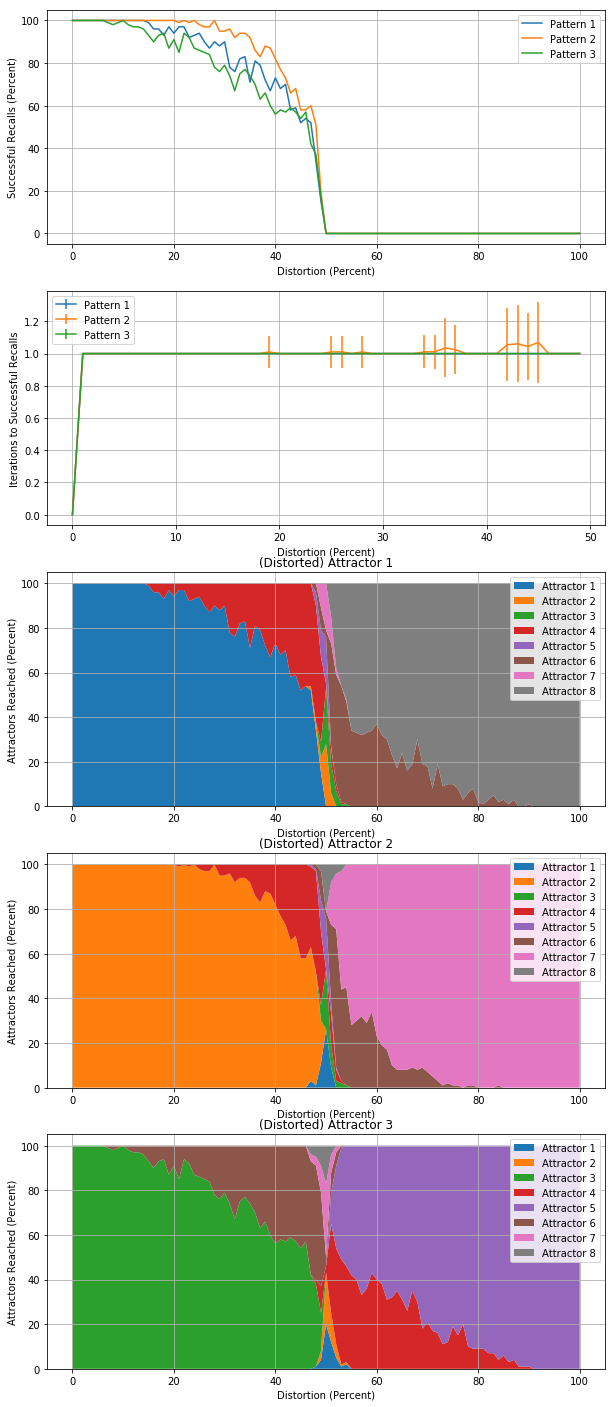

In [27]:
profile_noise_resistance(model_pict, patterns_list=[pattern for pattern in pict[:3,:]])

### 3.5. Capacity

Now add more and more memories to the network to see where the limit is. Start by adding p4 into the weight matrix and check if moderately distorted patters can still be recognized. Then continue by adding others such as p5, p6 and p7 in some order and checking the performance after each addition.

- How many patterns could safely be stored? Was the drop in performance gradual or abrupt?

- Try to repeat this with learning a few random patterns instead of the pictures and see if you can store more.

- It has been shown that the capacity of a Hopfield network is around 0.138*N. How do you explain the dierence between random patterns and the pictures?

In [28]:
def profile_capacity(n_patterns, patterns_list=None, random_patterns=False, dim_patterns=None, 
                     dim_distortion=0, bias=0, remove_self_connections=False):
    
    fig = plt.figure(figsize=(5,5))
    
    # Create patterns if random_patterns selected
    if random_patterns:
        if bias==0:
            patterns_list = [np.random.choice([-1,1], size=dim_patterns).astype(int) \
                             for _ in range(n_patterns)]
        else:
            patterns_list = [np.sign(bias+np.random.randn(dim_patterns)) for _ in range(n_patterns)]
            for i in range(len(patterns_list)):
                patterns_list[i][patterns_list[i]==0] = 1
    else:
        dim_patterns = patterns_list[0].shape[0]
    
    # Iterate number of patterns for training
    successes_async = []
    successes_sync = []
    for n in range(1,n_patterns+1):
        sys.stdout.write("{} patterns".format(n)+"\r")
        
        # Train Hopfield Network with n patterns
        model = HopfieldNetwork()
        model.train(patterns_list[:n], synchronous=True, check=False)
        if remove_self_connections:
            for i in range(dim_patterns):
                model.weights[i,i] = 0
        
        # Iterate patterns used for training and check recall
        success_async = 0
        success_sync = 0
        for pattern in patterns_list[:n]:
            
            # Create noise in the pattern in as much dimensions as dim_distortion
            pattern_noisy = pattern.copy()
            to_flip = np.random.choice(len(pattern_noisy), size=dim_distortion, replace=False)
            pattern_noisy[to_flip] *= -1
            
            # Check stability for async. updates
            pattern_noisy_updated = pattern_noisy
            for _ in range(len(pattern)):
                pattern_noisy_updated = model.update(pattern_noisy_updated, synchronous=False)
            if np.array_equal(pattern_noisy_updated, pattern):
                success_async += 1
            
            # Check stability for sync. updates
            pattern_noisy_updated = model.update(pattern_noisy, synchronous=True)
            if np.array_equal(pattern_noisy_updated, pattern):
                success_sync += 1
        
        # Store well memorised patterns
        successes_async.append(success_async)
        successes_sync.append(success_sync)
    
    # Plot well memorised patterns by # of patterns used for training
    plt.plot(range(1, n_patterns+1), successes_async, label="Asynchronous Updates")
    plt.plot(range(1, n_patterns+1), successes_sync, label="Synchronous Updates")
    plt.title("Pattern dimension {} with {} distorted".format(dim_patterns, dim_distortion))
    plt.xlabel("Number of training patterns")
    plt.ylabel("Well memorised patterns")
    plt.legend()
    plt.grid(True)

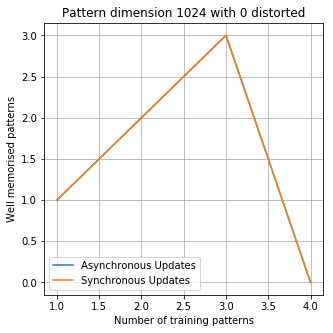

In [29]:
profile_capacity(patterns_list=list(pict), n_patterns=4)

Create 300 random patterns and train a 100-unit (or larger) network with them. After each new pattern has been added to the weight matrix, calculate how many of the earlier patterns remain stable (a single iteration does not cause them to change) and plot it.
-  What happens with the number of stable patterns as more are learned?

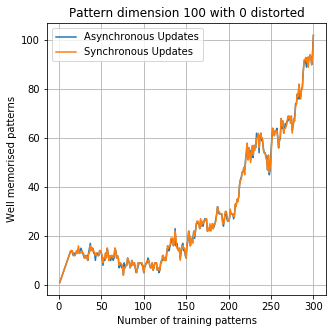

In [30]:
profile_capacity(n_patterns=300, random_patterns=True, dim_patterns=100)

-  What happens if convergence to the pattern from a noisy version (a few ipped units) is used? What does the different behavior for large number of patterns mean?

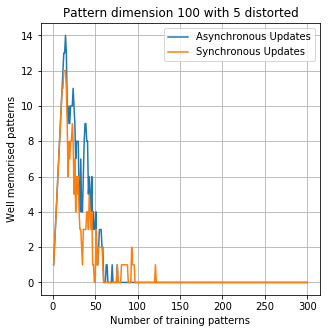

In [31]:
profile_capacity(n_patterns=300, random_patterns=True, dim_patterns=100, dim_distortion=5)

The self-connections wii are always positive and quite strong; they always support units to remain at their current state. If you remove them and compare the curves from pure and noisy patterns for large number of patterns you will see that the difference goes away. In general it is a good idea to remove self- connections, even though it seems that this step lowers the memory performance.

In fact, self-connections promote the formation of spurious patterns and have negative effect on noise removal capabilities.
-  What is the maximum number of retrievable patterns for this network?

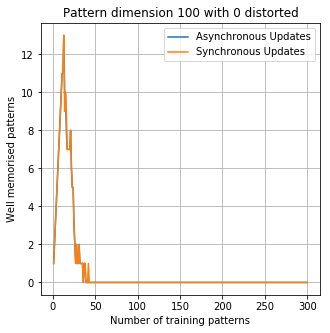

In [32]:
profile_capacity(n_patterns=300, random_patterns=True, dim_patterns=100, remove_self_connections=True)

- What happens if you bias the patterns, e.g. use sign(0.5+randn(300,100)) or something similar to make them contain more +1?How does this relate to the capacity results of the picture patterns?

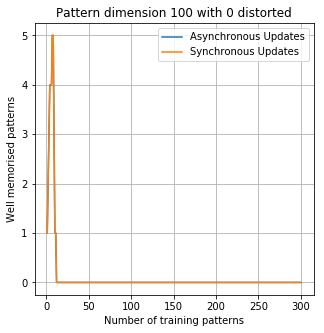

In [33]:
profile_capacity(n_patterns=300, random_patterns=True, dim_patterns=100, bias=0.5, 
                 remove_self_connections=True)

### 3.6 Sparse Patterns

The reduction in capacity because of bias is troublesome, since real data usually is not evenly balanced.

- Try generating sparse patterns with just 10% activity and see how many can be stored for different values of bias (use a script to check different values of the bias).

In [37]:
def profile_sparse_storage(num_patterns_var, num_patterns_fixed, biases_var, biases_fixed,
                           pattern_size=300, pattern_activity=0.1, synchronous=True):
    fig = plt.figure(figsize=(15,5))
    
    # Left Plot: percentage of well recall by some fixed biases and several num_patterns for training
    fig.add_subplot(121)
    
    # Iterate biases
    for bias in biases_fixed:
        model = HopfieldNetwork(bias=bias)
        
        # Iterate number of patterns for training
        successes_by_num_patterns = []
        for n in num_patterns_var:
            successes = 0
            
            # Iterate 100 random initializations for initializing patterns
            for _ in range(100):
                
                # Create sparse patterns
                n_ones = int(pattern_activity*pattern_size*n)
                patterns = np.zeros(n*pattern_size, dtype=np.int8)
                indexes_ones = np.random.choice(len(patterns), size=n_ones, replace=False)
                patterns[indexes_ones] = 1
                patterns = np.hsplit(patterns, n)
                
                # Train model with sparse patterns
                successes_model = model.train(patterns, synchronous=synchronous, 
                                              average_activity=pattern_activity, check=True, warn=False)
                
                # Sum 1 success if all patterns well memorised (check=True)
                successes += successes_model==len(patterns)
            
            successes_by_num_patterns.append(successes)
        
        # Plot the successes by num_patterns
        plt.plot(num_patterns_var, successes_by_num_patterns, label=r"$\Theta = {:.3f}$".format(bias))
    
    plt.xlabel("Number of patterns for training")
    plt.ylabel("Percent of success: all training patterns well memorised")
    plt.xticks(num_patterns_var)
    plt.legend()
    
    # Right plot: percentage of well recall by biases and sme fixed num_patterns for training
    fig.add_subplot(122)
    
    # Iterate number of patterns for training
    for n in num_patterns_fixed:
        successes_by_biases = []
        
        # Iterate biases
        for bias in biases_var:
            model = HopfieldNetwork(bias=bias)
            successes = 0
            
            # Iterate 100 random initializations for initializing patterns
            for _ in range(100):
                
                # Create sparse patterns
                n_ones = int(pattern_activity*pattern_size*n)
                patterns = np.zeros(n*pattern_size, dtype=np.int8)
                indexes_ones = np.random.choice(len(patterns), size=n_ones, replace=False)
                patterns[indexes_ones] = 1
                patterns = np.hsplit(patterns, n)
                
                # Train model with sparse patterns
                successes_model = model.train(patterns, synchronous=synchronous, 
                                              average_activity=pattern_activity, check=True, warn=False)
                
                # Sum 1 success if all patterns well memorised (check=True)
                successes += successes_model==len(patterns)
            
            successes_by_biases.append(successes)
        
        # Plot the successes by biases
        plt.plot(biases_var, successes_by_biases, label="{} Patterns".format(n))
    
    plt.xlabel(" $\Theta$ Bias")
    plt.ylabel("Percent of success: all training patterns well memorised")
    plt.legend()

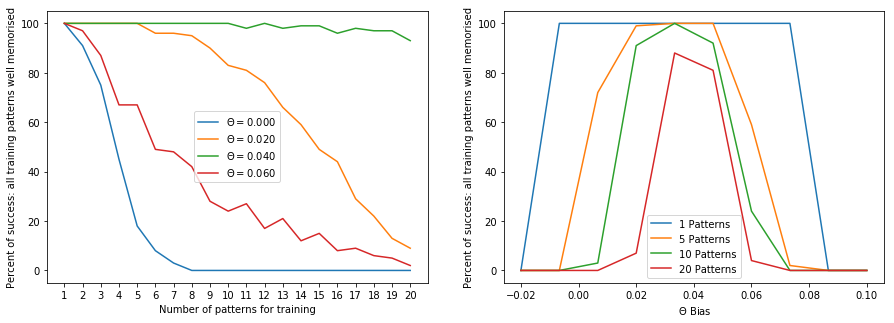

In [39]:
profile_sparse_storage(num_patterns_var=range(1, 21),
                       num_patterns_fixed=[1,5,10,20],
                       biases_var=np.linspace(-0.02, 0.1, 10),
                       biases_fixed=np.arange(0, 0.08, 0.02),
                       pattern_size=300,
                       pattern_activity=0.1,
                       synchronous=True)

- What about even sparser patterns (activity = 0.05 or 0.01)?

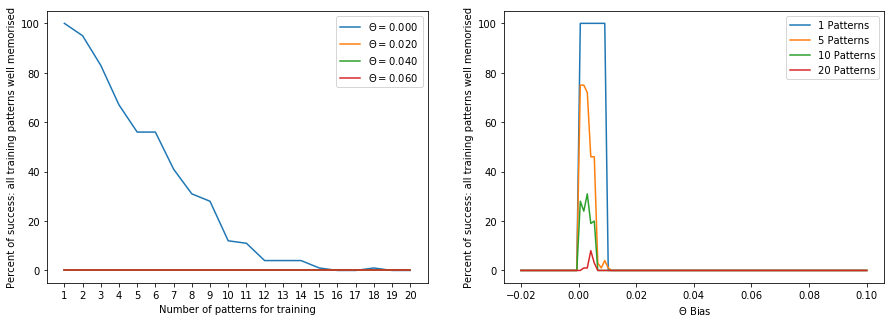

In [38]:
profile_sparse_storage(num_patterns_var=range(1, 21),
                       num_patterns_fixed=[1,5,10,20],
                       biases_var=np.linspace(-0.02, 0.1, 100),
                       biases_fixed=np.arange(0, 0.08, 0.02),
                       pattern_size=300,
                       pattern_activity=0.01,
                       synchronous=True)